In [1]:
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import itertools
import math
import pandas as pd
from PIL import Image, ImageDraw
rng = np.random.default_rng()


In [2]:
%%bash
slim -s 119 -d R0=10 -d 'OUTPUT="bearded_seal_parents.csv"' -d 'POPSIZE_FILE="bearded_seal_popsize.csv"' bearded_seals/bearded_seals.slim

// Initial random seed:
119

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeSex("A");
22026
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.56419, sexSegregation="FM");
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeMutationRate(0);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 

"Late pop size"
17536
"Late pop size"
17529
"Late pop size"
17446
"Late pop size"
17509
"Late pop size"
17534
"Late pop size"
17477
"Late pop size"
17467
"Late pop size"
17554
"Late pop size"
17497
"Late pop size"
17559
"Late pop size"
17533
"Late pop size"
17532
"Late pop size"
17439
"Late pop size"
17399
"Late pop size"
17338
"Late pop size"
17211
"Late pop size"
17189
"Late pop size"
17201
"Late pop size"
17192
"Late pop size"
17133
"Late pop size"
17121
"Late pop size"
17122
"Late po

In [2]:
parents = pd.read_csv("bearded_seal_parents.csv")

### Define a sampling intensity grid and sample from dead animals for each year according to the grid

In [3]:
def sample_cell_year(sample_parents, year, xmin, xmax, ymin, ymax, nmax):
    # Sample from individuals within one grid cell
    in_x = np.logical_and(sample_parents.loc[:,'x'] <= xmax, sample_parents.loc[:,'x'] >= xmin)
    in_y = np.logical_and(sample_parents.loc[:,'y'] >= ymin, sample_parents.loc[:,'y'] <= ymax)
    in_cell = np.logical_and(in_x, in_y)
    in_year = sample_parents.loc[:,'sampling_time'] == year
    in_i = np.where(np.logical_and(in_cell, in_year))[0]
    # Sample size is nmax or the number of individuals in the area
    ss = min(len(in_i), nmax)
    sample_rows = rng.choice(in_i, ss, replace = False)
    return(ss, sample_rows)

In [4]:
def sample_grid_years(individuals, years, sampling_intensity, n, width = 10, height = 10):
    # Sample from each grid cell
    # Sample size 
    ss = np.array(np.floor(n*sampling_intensity/(np.sum(sampling_intensity)*len(years))), dtype = int)
    # Keep track of actual total sample size (since if there are fewer than ss individuals in a grid cell, all are sampled)
    realized_ss = 0
    
    # Width and height of grid cells
    x_cells = ss.shape[0]
    y_cells = ss.shape[1]
    dx = width/x_cells
    dy = height/y_cells
    
    # Keep track of sampled rows
    #sample_rows = np.empty(round(np.sum(ss)), dtype = int)
    sample_rows = np.empty(0, dtype = int)
    # Sample from each grid cell
    for ix, iy in np.ndindex(ss.shape):
        for year in years:
            xmin = dx*ix
            xmax = dx*ix + dx
            ymin = dy*iy
            ymax = dy*iy + dy
            nmax = ss[ix, iy]
            grid_year_ss, grid_rows = sample_cell_year(individuals, year, xmin, xmax, ymin, ymax, nmax)
            sample_rows = np.concatenate([sample_rows, grid_rows])
            realized_ss += grid_year_ss
    return(realized_ss, sample_rows)

In [5]:
def sample_grid(individuals, sampling_intensity, n, width = 10, height = 10):
    # Sample from each grid cell
    # Sample size 
    ss = np.array(np.ceil(n*sampling_intensity/np.sum(sampling_intensity)), dtype = int)
    # Keep track of actual sample sizes (since if there are fewer than ss individuals in a grid cell, all are sampled)
    realized_ss = np.zeros(ss.shape, dtype = int)
    
    # Width and height of grid cells
    x_cells = ss.shape[0]
    y_cells = ss.shape[1]
    dx = width/x_cells
    dy = height/y_cells
    
    # Keep track of sampled rows
    #sample_rows = np.empty(round(np.sum(ss)), dtype = int)
    sample_rows = np.empty(0, dtype = int)
    # Sample from each grid cell
    for ix, iy in np.ndindex(ss.shape):
        xmin = dx*ix
        xmax = dx*ix + dx
        ymin = dy*iy
        ymax = dy*iy + dy
        nmax = ss[ix, iy]
        realized_ss[ix, iy], grid_rows = sample_cell(individuals, xmin, xmax, ymin, ymax, nmax)
        sample_rows = np.concatenate([sample_rows, grid_rows])
    return(realized_ss, sample_rows)

In [6]:
def sample_cell(sample_parents, xmin, xmax, ymin, ymax, nmax):
    # Sample from individuals within one grid cell
    in_i = np.where(np.logical_and(np.logical_and(sample_parents.loc[:,'x'] <= xmax, sample_parents.loc[:,'x'] >= xmin),
                np.logical_and(sample_parents.loc[:,'y'] >= ymin, sample_parents.loc[:,'y'] <= ymax)))[0]
    # Sample size is nmax or the number of individuals in the area
    ss = min(len(in_i), nmax)
    sample_rows = rng.choice(in_i, ss, replace = False)
    return(ss, sample_rows)

### Make plots of sample

In [7]:
def make_spaghetti(sample_parents, image_w, image_h, max_width, max_height):
    # creating new Image object
    w, h = image_w, image_h
    spaghetti = Image.new("1", (w, h))
    img1 = ImageDraw.Draw(spaghetti)

    # Find individuals with a parent that is in the sample
    p_in_i = np.isin(sample_parents.loc[:,'parent1'], sample_parents.loc[:,'individual'])
    npairs = sum(p_in_i)

    # Get location of parent-offspring pairs and plot
    children = sample_parents.loc[p_in_i, :]
    for child_i, child_row in children.iterrows():
        parent_i = np.where(sample_parents.loc[:,'individual'] == child_row['parent1'])[0][0]
        parent_row = sample_parents.iloc[parent_i,:]
        # print(parent_row['individual'], child_row['individual'])
        x_child, y_child = child_row[['x','y']]
        x_parent, y_parent = parent_row[['x','y']]
        img1.line([(x_child*w/max_width, y_child*h/max_height), (x_parent*w/max_width, y_parent*h/max_height)], fill ="white", width = 0)

    return(spaghetti, npairs)

In [8]:
def plot_samples(sample_parents, image_w, image_h, max_width, max_height):
    # creating new Image object
    w, h = image_w, image_h
    sampling = Image.new("1", (w, h))
    img2 = ImageDraw.Draw(sampling)

    # Plot sampling
    for ind_i, ind_row in sample_parents.iterrows():
        x, y = ind_row[['x','y']]
        img2.point((x*w/max_width, y*h/max_height), fill = "white")
    return(sampling)

In [9]:
max_bias = 10
def plot_intensity(sampling_intensity, image_w, image_h, max_int = max_bias):
    w, h = image_w, image_h
    intensity = Image.new("L", (w, h))
    img3 = ImageDraw.Draw(intensity)

    # Width and height of grid cells
    x_cells = sampling_intensity.shape[0]
    y_cells = sampling_intensity.shape[1]
    dx = w/x_cells
    dy = h/y_cells
    # Maximum sampling intensity (will be 255 or all white)
    # Plot sampling intensity
    for ix, iy in np.ndindex(sampling_intensity.shape):
        xmin = dx*ix
        xmax = dx*ix + dx
        ymin = dy*iy
        ymax = dy*iy + dy
        # Sampling
        rel_intensity = round(255*sampling_intensity[ix, iy]/max_int)
        img3.rectangle([(xmin, ymin), (xmax, ymax)], fill = rel_intensity, outline=None, width=0)
    return(intensity)

In [10]:
# Divide into years and sample for each year
sample_years = np.unique(parents.loc[:,'sampling_time'])
print(sample_years) 

[40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]


### Maternal and paternal POPs separately

In [11]:
def find_POPs_or_sibs(focal_parents, sample_array, type):
    # focal_parents: List of individual IDs of the focal parents. The focal parents do not need to be in the sample.
    # sample_array: Array of information about the whole sample
    # type: "PO" or "HS"
    #   "PO": find pairs with parent in focal_parent_array and offspring in sample_array
    #   "sib": find pairs of children in sample_array that share a parent in focal_parent_array
    # Returns:
    # An array of tuples of either [(parent, offspring), ...] or [(sibling 1, sibling 2), ...]
    relative_pairs = []
    for parent_id in focal_parents:
        #print("Parent", parent_id)
        children = sample_array[np.logical_or(sample_array.loc[:,'parent1'] == parent_id,
                                        sample_array.loc[:,'parent2'] == parent_id)]
        #print("Children")
        #print(children)
        if type == "PO":
        # Record POPs
            for j, child in children.iterrows():
                child_id = child['individual']
                relative_pairs.append((parent_id, child_id))
        if type == "HS":
            if len(children) == 2:
                sib_ids = children.loc[:,'individual'].values
                relative_pairs.append(tuple(np.sort(sib_ids)))
            if len(children) > 2:
                for pair in itertools.combinations(children.loc[:,'individual'], 2):
                    relative_pairs.append(tuple(np.sort(pair)))
    return(relative_pairs)            

In [12]:
# Sample
max_bias = 10
sampling_intensity =  np.repeat([np.linspace(1, max_bias, 10)], 10, axis = 0)
ss, sample_rows = sample_grid(parents, sampling_intensity, 2000, 10, 10)
sample_parents = parents.iloc[sample_rows]

In [21]:
# Find individuals with a parent that is in the sample
p1_in_i = np.isin(sample_parents.loc[:,'parent1'], sample_parents.loc[:,'individual'])
p2_in_i = np.isin(sample_parents.loc[:,'parent2'], sample_parents.loc[:,'individual'])
# Number of individuals with both parents in the sample
both_i = np.logical_and(p1_in_i,p2_in_i)
n_both = sum(both_i)
both = sample_parents[both_i]
print(both)
print(n_both)

# Female and male rows
ind_female = sample_parents.loc[:,'sex'] == "F"
ind_male = sample_parents.loc[:,'sex'] == "M"

# Individuals in the sample that have a child in the sample
ind_in_p1 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent1'])
ind_in_p2 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent2'])
ind_in_p = np.logical_or(ind_in_p1, ind_in_p2)
print(sum(ind_in_p))

# Mothers and Fathers
#mothers = sample_parents[np.logical_and(ind_in_p, ind_female)]
#fathers = sample_parents[np.logical_and(ind_in_p, ind_male)]
mothers = sample_parents[ind_in_p1]
fathers = sample_parents[ind_in_p2]
mother_list = mothers.loc[:,'individual'].values
father_list = fathers.loc[:,'individual'].values
print("Number of mothers in the sample", len(mother_list))
print("Number of fathers in the sample", len(father_list))

# Find the parents of children in the sample and how many children in the sample they have (the parents don't need to be in the sample)
# Mothers are parent1 and fathers are parent2
all_mothers, all_mother_counts = np.unique(sample_parents.loc[:,'parent1'].values, return_counts = True)
all_fathers, all_father_counts = np.unique(sample_parents.loc[:,'parent2'].values, return_counts = True)

print(sum(all_mother_counts))
print(sum(all_father_counts))
print(len(sample_parents))

# Parents with multiple children in the sample
maternal_sib_parents = all_mothers[all_mother_counts > 1]
paternal_sib_parents = all_fathers[all_father_counts > 1]
print("Number of mothers with multiple children in the sample", len(maternal_sib_parents))
print("Number of fathers with multiple children in the sample", len(paternal_sib_parents))


       individual  parent1  parent2  age sex  sampling_time        x        y
50244      203064   166225   199104   10   M             51  7.50945  9.97969
1
77
Number of mothers in the sample 42
Number of fathers in the sample 35
2050
2050
2050
Number of mothers with multiple children in the sample 128
Number of fathers with multiple children in the sample 101


In [22]:
maternal_pops = find_POPs_or_sibs(mother_list, sample_parents, "PO")
paternal_pops = find_POPs_or_sibs(father_list, sample_parents, "PO")
maternal_sibs = find_POPs_or_sibs(maternal_sib_parents, sample_parents, "HS")
paternal_sibs = find_POPs_or_sibs(paternal_sib_parents, sample_parents, "HS")
print("# maternal POPs", len(maternal_pops))
print("# paternal POPs", len(paternal_pops))
print("# maternal sibs", len(maternal_sibs))
print("# paternal sibs", len(paternal_sibs))
print(maternal_pops)
print(maternal_sibs)
# Full sibling pairs appear in both maternal and paternal arrays
if np.any([x in paternal_sibs for x in maternal_sibs]):
    full_sibs = maternal_sibs[np.where([x in paternal_sibs for x in maternal_sibs])[0][0]]
else:
    full_sibs = []
print("Full sibs", full_sibs)
# Individuals with both parents in the sample
print("# individuals with both parents in the sample")
print(np.sum(np.isin(np.array(maternal_pops)[:,1], np.array(paternal_pops)[:,1])))
both_in_i = np.where(np.isin(np.array(maternal_pops)[:,1], np.array(paternal_pops)[:,1]))
print(np.array(maternal_pops)[both_in_i[0], :])

# maternal POPs 47
# paternal POPs 37
# maternal sibs 149
# paternal sibs 120
[(157935, 197667), (138251, 178239), (191736, 238125), (201431, 236423), (149740, 190654), (149740, 194200), (161087, 192953), (128218, 200415), (171708, 204720), (178976, 238268), (183465, 201526), (173871, 264563), (228678, 265058), (213075, 242368), (224340, 267035), (190788, 210520), (171218, 202105), (161038, 199542), (235309, 261127), (235309, 252044), (209045, 273352), (205368, 250045), (185620, 204337), (156757, 201978), (209833, 216542), (245817, 267350), (183722, 225411), (183722, 230096), (172183, 198654), (135274, 206645), (211237, 221878), (86889, 216549), (191888, 271724), (191888, 245191), (211034, 256089), (141984, 190680), (148506, 199520), (165958, 230329), (173006, 215454), (189591, 242341), (182693, 208742), (168032, 189360), (168032, 206900), (219406, 234310), (217204, 261450), (191131, 209045), (166225, 203064)]
[(205763, 216989), (174834, 181650), (140523, 152825), (185903, 211738), (15

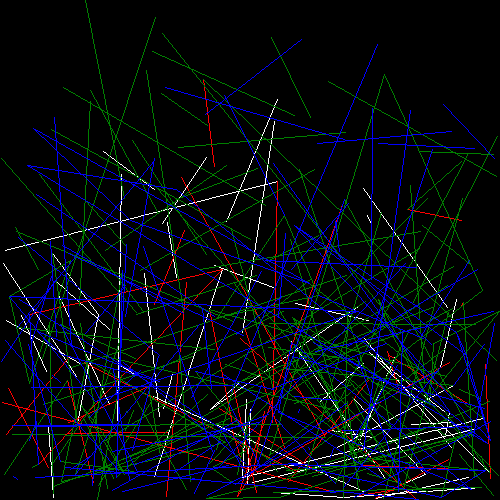

In [23]:
# Get location of parent-offspring pairs and plot
# creating new Image object
w, h = 500, 500
max_width = 10
max_height = 10
spaghetti = Image.new("RGB", (w, h))
img1 = ImageDraw.Draw(spaghetti)
def draw_pairs(pairs, image, sample_array, max_width, max_height, color = "white"):
    # pairs: An array of tuples of individual ids
    # image: An image object to add lines to
    # sample_array: Array containing information about each individual
    for pair in pairs:
        index1 = np.where(sample_array.loc[:,'individual'] == pair[0])
        index2 = np.where(sample_array.loc[:,'individual'] == pair[1])
        row1 = sample_array.iloc[index1]
        row2 = sample_array.iloc[index2]
        x1, y1 = row1[['x', 'y']].values[0]
        x2, y2 = row2[['x', 'y']].values[0]
        image.line([(x1*w/max_width, y1*h/max_height), (x2*w/max_width, y2*h/max_height)], fill =color, width = 0)

draw_pairs(maternal_pops, img1, sample_parents, max_width, max_height)
draw_pairs(paternal_pops, img1, sample_parents, max_width, max_height, "red")
draw_pairs(maternal_sibs, img1, sample_parents, max_width, max_height, "green")
draw_pairs(paternal_sibs, img1, sample_parents, max_width, max_height, "blue")
display(spaghetti)

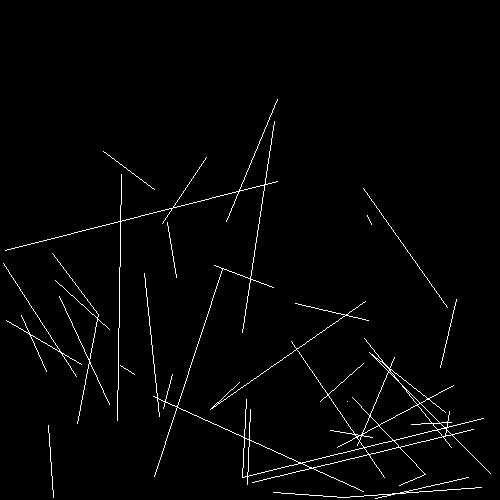

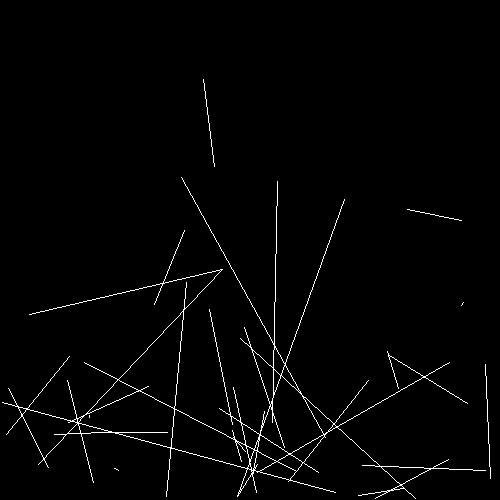

In [24]:
w, h = 500, 500
max_width = 10
max_height = 10
maternal_pops_image = Image.new("1", (w, h))
img2 = ImageDraw.Draw(maternal_pops_image)
draw_pairs(maternal_pops, img2, sample_parents, max_width, max_height)
display(maternal_pops_image)
paternal_pops_image = Image.new("1", (w, h))
img3 = ImageDraw.Draw(paternal_pops_image)
draw_pairs(paternal_pops, img3, sample_parents, max_width, max_height)
display(paternal_pops_image)

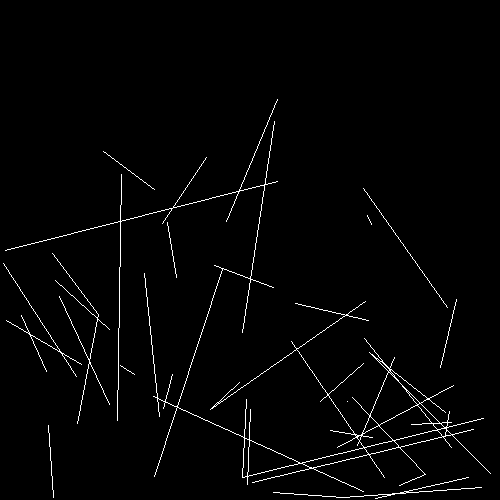

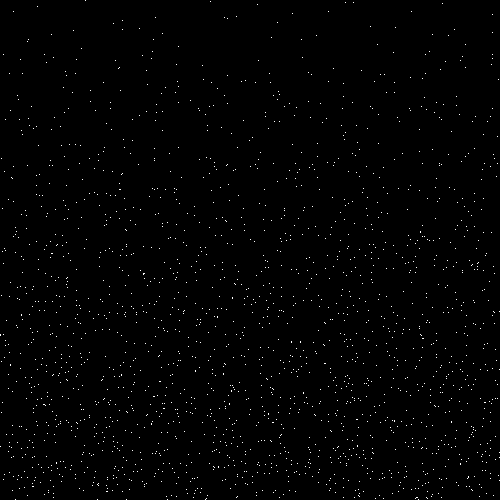

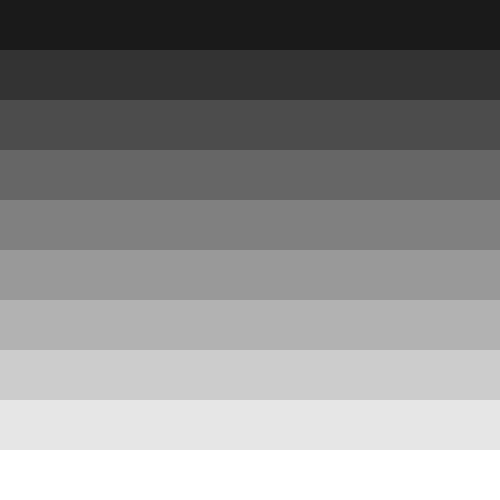

In [16]:
display(make_spaghetti(sample_parents, 500, 500, 10, 10)[0])
display(plot_samples(sample_parents, 500, 500, 10, 10))
display(plot_intensity(sampling_intensity, 500, 500))

In [13]:
popsize = pd.read_csv("bearded_seal_popsize.csv")

In [14]:
print(popsize)
print(popsize.columns)
np.mean(popsize.loc[:,'N'])

    sampling_time      N
0              40  18013
1              41  17995
2              42  17997
3              43  17923
4              44  17772
5              45  17693
6              46  17630
7              47  17459
8              48  17398
9              49  17354
10             50  17397
11             51  17438
12             52  17391
13             53  17305
14             54  17267
15             55  17206
16             56  17111
17             57  17026
18             58  16936
19             59  16951
20             60  16873
Index(['sampling_time', 'N'], dtype='object')


17435.0

In [16]:
np.sum(ss)

1050